# Installation

In [1]:
!pip uninstall -y gensim
!pip install gensim==4.1.2
!pip install torchdata
!pip install flair
!pip install nlpaug
!pip install sacremoses

!pip install gdown==4.4
!gdown https://drive.google.com/uc?id=1v4JA7gvNWoLT1Kxj-1D0JtOXCOOanldJ
!mv '/content/GoogleNews-vectors-negative300 (1).bin.gz' /content/GoogleNews-vectors-negative300.bin.gz
!gzip -d /content/GoogleNews-vectors-negative300.bin.gz

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2
  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flair 0.11.2 requires gdown==3.12.2, but you have gdown 4.4.0 which is incompatible.
  Using cached gdown-3.12.2-py3-none-any.whl
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
  Using cached gdown-4.4.0-py3-none-any.whl
  Attempting uninstall: gdown
    Found existing installation: gdown 3.12.2
    Uninstalling gdown-3.12.2:
      Successfully uninstalled gdown-3.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the foll

# Imports

In [2]:
# Math
import torch
import numpy as np

# Flair Device
import flair
flair.device = torch.device('cuda')

# Analysis
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Downloading Packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Autoencoder and Dataset Preparation
from data.imdb_preparation import IMDB_preparation
from data.ag_news_preparation import AG_NEWS_preparation
from autoencoders.autoencoder import Autoencoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2022-05-16 17:55:16,059 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpzarfbozo


100%|██████████| 160000128/160000128 [00:08<00:00, 18645950.86B/s]

2022-05-16 17:55:25,035 copying /tmp/tmpzarfbozo to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2022-05-16 17:55:25,415 removing temp file /tmp/tmpzarfbozo
2022-05-16 17:55:25,818 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpk04lidvz


100%|██████████| 21494764/21494764 [00:01<00:00, 11132819.30B/s]

2022-05-16 17:55:28,160 copying /tmp/tmpk04lidvz to cache at /root/.flair/embeddings/glove.gensim
2022-05-16 17:55:28,201 removing temp file /tmp/tmpk04lidvz


# 1. Vanilla Autoencoder

## 1.1 Loading Data

In [3]:
ds = AG_NEWS_preparation()

Preparing sentences...


100%|██████████| 120000/120000 [04:45<00:00, 421.04it/s]


Making sentences...


100%|██████████| 120000/120000 [01:41<00:00, 1185.30it/s]


Embedding sentences...


100%|██████████| 120000/120000 [01:13<00:00, 1636.58it/s]


Splitting sentences...


100%|██████████| 120000/120000 [00:05<00:00, 21206.71it/s]

Done!


In [ ]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])

In [ ]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True)

## 1.2 Training loop

In [4]:
m = Autoencoder(100,100,100,4,3,variational=False, max_log2len=8)
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [5]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [6]:
m = m.train()
EPOCHS = 12
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    m = m.train()
    pbar = tqdm(dl_train)
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx = m(x_in)
        L = (mx - x_out).pow(2).sum((1,2)).mean()
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()}")
        Ls_train.append(L.item())
    
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

Epoch: 0


L: 232.1025390625: 100%|██████████| 9381/9381 [11:35<00:00, 13.49it/s]


Epoch: 1


L: 176.68414306640625: 100%|██████████| 9381/9381 [11:27<00:00, 13.65it/s]


Epoch: 2


L: 171.73397827148438: 100%|██████████| 9381/9381 [11:22<00:00, 13.74it/s]


Epoch: 3


L: 155.9964141845703: 100%|██████████| 9381/9381 [11:12<00:00, 13.95it/s]


Epoch: 4


L: 160.8627471923828: 100%|██████████| 9381/9381 [11:13<00:00, 13.93it/s]


Epoch: 5


L: 135.830810546875: 100%|██████████| 9381/9381 [11:11<00:00, 13.97it/s]


Epoch: 6


L: 139.71621704101562: 100%|██████████| 9381/9381 [11:16<00:00, 13.87it/s]


Epoch: 7


L: 154.65536499023438: 100%|██████████| 9381/9381 [11:29<00:00, 13.61it/s]


Epoch: 8


L: 144.53768920898438: 100%|██████████| 9381/9381 [11:22<00:00, 13.74it/s]


Epoch: 9


L: 143.78427124023438: 100%|██████████| 9381/9381 [10:59<00:00, 14.23it/s]


Epoch: 10


L: 116.56059265136719: 100%|██████████| 9381/9381 [11:11<00:00, 13.97it/s]


Epoch: 11


L: 124.08885192871094: 100%|██████████| 9381/9381 [11:07<00:00, 14.05it/s]


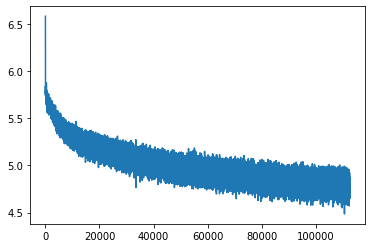

In [7]:
plt.plot(np.log(Ls))

The traing of AG_NEWS has higher variance for batches. The training is slow, but the loss decreases. Importantly, the MSE loss for the vanilla autoencoder is lower than for the VAE and DAE. Despite that, as for the IMDB, the validation loss closely matches the training loss.

In [ ]:
m = Autoencoder(100,100,100,4,3,variational=False, max_log2len=8)
Ls = []
device = 'cpu'
m = m.to(device)

In [ ]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
m = m.train()
EPOCHS = 3
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    pbar = tqdm(dl)
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx = m(x_in)
        L = (mx - x_out).pow(2).sum((1,2)).mean()
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()}")
        Ls.append(L.item())

In [ ]:
plt.plot(np.log(Ls))